In [4]:
import gensim.models.keyedvectors as word2vec #need to use due to depreceated model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Reshape, dot, Input, LSTM, Conv1D, \
Dense, Flatten, MaxPooling1D, Dropout, Embedding, BatchNormalization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report

import logging

from tqdm import tqdm

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
booksData = pd.read_csv('bookv4-clean(0-1).csv')

books = booksData['text']
labels = booksData['polarity']

1    37500
0    37500
Name: polarity, dtype: int64


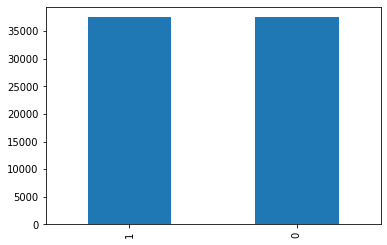

In [6]:
labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())

In [7]:
train_samples, test_samples, train_labels, test_labels = train_test_split(books, labels, test_size=0.1, random_state=24)

train_samples, val_samples, train_labels, val_labels = train_test_split(train_samples, train_labels, test_size=0.15, random_state=24) # 0.15 x 0.9 = 0.135

In [27]:
MAX_LEN = 250

In [28]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=MAX_LEN)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [29]:
"""
We can retrieve the computed vocabulary used via `vectorizer.get_vocabulary()`. Let's
print the top 5 words:
"""
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'be', 'and']

In [30]:
"""
Let's vectorize a test sentence:
"""

output = vectorizer([["i fell in love with the book i read"]])
output.numpy()[0, :9]

array([  5, 947,  12,  68,  20,   2,   8,   5,  16])

In [31]:
"""
As we can see, "the" gets represented as "2". Why not 0, given that "book" was the first
word in the vocabulary? That's because index 0 is reserved for padding and index 1 is
reserved for "out of vocabulary" tokens.
Here's a dict mapping words to their indices:
"""

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

word_index

{'': 0,
 '[UNK]': 1,
 'the': 2,
 'be': 3,
 'and': 4,
 'i': 5,
 'to': 6,
 'a': 7,
 'book': 8,
 'of': 9,
 'this': 10,
 'it': 11,
 'in': 12,
 'have': 13,
 'that': 14,
 'for': 15,
 'read': 16,
 'you': 17,
 'not': 18,
 'but': 19,
 'with': 20,
 'as': 21,
 'on': 22,
 'my': 23,
 'one': 24,
 'do': 25,
 'about': 26,
 'all': 27,
 'like': 28,
 'if': 29,
 'so': 30,
 'good': 31,
 'very': 32,
 'an': 33,
 'get': 34,
 'at': 35,
 'his': 36,
 'story': 37,
 'by': 38,
 'or': 39,
 'me': 40,
 'he': 41,
 'from': 42,
 'would': 43,
 'its': 44,
 'just': 45,
 'what': 46,
 'time': 47,
 'more': 48,
 'write': 49,
 'who': 50,
 'make': 51,
 'find': 52,
 'there': 53,
 'her': 54,
 'think': 55,
 'out': 56,
 'will': 57,
 'great': 58,
 'character': 59,
 'author': 60,
 'some': 61,
 'can': 62,
 'they': 63,
 'really': 64,
 'go': 65,
 'how': 66,
 'when': 67,
 'love': 68,
 'much': 69,
 'well': 70,
 'up': 71,
 'no': 72,
 'she': 73,
 'first': 74,
 'only': 75,
 'other': 76,
 'your': 77,
 'know': 78,
 'give': 79,
 'dont': 80,
 'bec

In [32]:
"""
We can see, we obtain the same encoding as above for our test sentence:
"""

test = ["i", "fell", "in", "love", "with", "the", "book", "i", "read"]
[word_index[w] for w in test]

[5, 947, 12, 68, 20, 2, 8, 5, 16]

In [33]:
import gensim
from gensim.models import Word2Vec

skip_w2vModel = gensim.models.Word2Vec.load("skipgram-word2vec.model")
cbow_w2vModel = gensim.models.Word2Vec.load("cbow-word2vec.model")

In [34]:
# Let's make a dict mapping words (strings) to their NumPy vector representation:
embeddings_index = {}
for w in cbow_w2vModel.wv.index_to_key:
    # TAKE MEAN OF BOTH VECTORS TO HAVE 100 DIMENSIONS OF VECTOR REPRESENTATION
    embeddings_index[w] = np.mean([cbow_w2vModel.wv[w], skip_w2vModel.wv[w]], axis=0) 

print("Found %s word vectors." % len(embeddings_index))

Found 54048 word vectors.


In [35]:
"""
Now, let's prepare a corresponding embedding matrix that we can use in a Keras
`Embedding` layer. It's a simple NumPy matrix where entry at index `i` is the pre-trained
vector for the word of index `i` in our `vectorizer`'s vocabulary.
"""

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 15554 words (4446 misses)


In [36]:
"""
Next, we load the pre-trained word embeddings matrix into an `Embedding` layer.
Note that we set `trainable=False` so as to keep the embeddings fixed (we don't want to
update them during training).
"""
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [37]:
def get_pos_tags(data):
    pos_tags = []
    for sample in tqdm(data):
        word_tokens = nltk.word_tokenize(sample)
        tagged = nltk.pos_tag(word_tokens)
        pos_tags.append(' '.join([tup[1] for tup in tagged]))
    return pos_tags

train_pos = get_pos_tags(train_samples)
test_pos = get_pos_tags(test_samples)
val_pos = get_pos_tags(val_samples)

100%|██████████| 10125/10125 [00:40<00:00, 252.88it/s]


In [19]:
# print(train_pos[0])

# pos_tokenizer = Tokenizer()
# pos_tokenizer.fit_on_texts(train_pos)


# train_pos_encoded = pos_tokenizer.texts_to_sequences(train_pos)
# test_pos_encoded = pos_tokenizer.texts_to_sequences(test_pos)
# val_pos_encoded = pos_tokenizer.texts_to_sequences(val_pos)

In [20]:
# from tensorflow.keras.utils import to_categorical

# train_pos_padded = pad_sequences(train_pos_encoded, maxlen=200, padding="post", truncating="post")
# test_pos_padded = pad_sequences(test_pos_encoded, maxlen=200, padding="post", truncating="post")
# val_pos_padded = pad_sequences(val_pos_encoded, maxlen=200, padding="post", truncating="post")

# # # use Keras' to_categorical function to one-hot encode Y
# # train_pos = to_categorical(train_pos_padded)
# # test_pos = to_categorical(test_pos_padded)
# # val_pos = to_categorical(val_pos_padded)

In [38]:
pos_vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=MAX_LEN)
pos_ds = tf.data.Dataset.from_tensor_slices(train_pos).batch(128)

pos_vectorizer.adapt(train_pos)

In [39]:
voc_pos = pos_vectorizer.get_vocabulary()

num_tokens_pos = len(voc_pos) + 2
embedding_dim_pos = 60

In [40]:
"""
Next, we load the pre-trained word embeddings matrix into an `Embedding` layer.
Note that we set `trainable=True` so as to train the embeddings
"""
embedding_layer_pos = Embedding(
    num_tokens_pos,
    embedding_dim_pos,
    trainable=True,
)

In [41]:
tokenized_sequence_input = Input(shape=(MAX_LEN, ), dtype="int64")
embedded_sequences = embedding_layer(tokenized_sequence_input)
embedded_sequences = BatchNormalization()(embedded_sequences)
conv_seq = Conv1D(filters=128, kernel_size=4, activation='relu', padding='causal')(embedded_sequences)

pos_input = Input(shape=(MAX_LEN, ), dtype="int64")
embedded_pos = embedding_layer_pos(pos_input)
embedded_pos = BatchNormalization()(embedded_pos)
conv_pos = Conv1D(filters=64, kernel_size=4, activation='relu', padding='causal')(embedded_pos)

x = Concatenate()([conv_seq, conv_pos])
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.4)(x)
x = LSTM(units=150)(x)
x = Dense(50)(x)
x = Dropout(0.3)(x)
out = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[tokenized_sequence_input, pos_input], outputs=out) 
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 250, 100)     2000200     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 250, 60)      2220        ['input_4[0][0]']                
                                                                                            

In [42]:
"""
## Train the model
First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays
are right-padded.
"""

x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

x_train_pos = pos_vectorizer(np.array([[s] for s in train_pos])).numpy()
x_test_pos = pos_vectorizer(np.array([[s] for s in test_pos])).numpy()
x_val_pos = pos_vectorizer(np.array([[s] for s in val_pos])).numpy()

y_train = np.array(train_labels)
y_test = np.array(test_labels)
y_val = np.array(val_labels)

In [43]:
model.fit([x_train, x_train_pos], y_train, batch_size=128, epochs=20, validation_data=([x_val, x_val_pos], y_val))

Epoch 1/20
449/449 [==============================] - 36s 72ms/step - loss: 0.6943 - accuracy: 0.5032 - val_loss: 0.6898 - val_accuracy: 0.5489
Epoch 2/20
449/449 [==============================] - 31s 69ms/step - loss: 0.6928 - accuracy: 0.5091 - val_loss: 0.6871 - val_accuracy: 0.4973
Epoch 3/20
449/449 [==============================] - 31s 70ms/step - loss: 0.4870 - accuracy: 0.7546 - val_loss: 0.4428 - val_accuracy: 0.7950
Epoch 4/20
449/449 [==============================] - 31s 70ms/step - loss: 0.3158 - accuracy: 0.8695 - val_loss: 0.2903 - val_accuracy: 0.8837
Epoch 5/20
449/449 [==============================] - 31s 70ms/step - loss: 0.2719 - accuracy: 0.8886 - val_loss: 0.3069 - val_accuracy: 0.8698
Epoch 6/20
449/449 [==============================] - 31s 70ms/step - loss: 0.2514 - accuracy: 0.8991 - val_loss: 0.2636 - val_accuracy: 0.8926
Epoch 7/20
449/449 [==============================] - 31s 70ms/step - loss: 0.2342 - accuracy: 0.9068 - val_loss: 0.2688 - val_accuracy:

In [44]:
#analyze the results
score, acc = model.evaluate([x_test, x_test_pos], y_test, verbose = 2, batch_size=32)
y_pred = model.predict([x_test, x_test_pos])

235/235 - 3s - loss: 0.2277 - accuracy: 0.9155 - 3s/epoch - 13ms/step


In [45]:
#ROC AUC curve
rocAuc = roc_auc_score(y_test, y_pred)

In [46]:
falsePositiveRate, truePositiveRate, _ = roc_curve(y_test, y_pred)

In [47]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

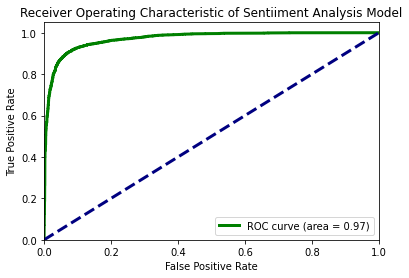

In [48]:
plt.plot(falsePositiveRate, truePositiveRate, color='green',
         lw=3, label='ROC curve (area = %0.2f)' % rocAuc)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Sentiiment Analysis Model')
plt.legend(loc="lower right")
plt.show()

In [49]:
#Other accuracy metrices
y_pred = (y_pred > 0.5)

In [50]:
#confusion metrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[3389  324]
 [ 310 3477]]


In [51]:
#F1 Score, Recall and Precision
print(classification_report(y_test, y_pred, target_names=['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive       0.92      0.91      0.91      3713
    Negative       0.91      0.92      0.92      3787

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500

